<div style="background-color: #f08721; color: white; padding: 20px 20px 20px 20px; border-radius: 15px; font-size: 16px; border: 2px solid #f5ab64;">
    <h1>Flexa Case Challenge</h1>
    <h3>Task 2 - Optimise profit of selling and buying energy. </h3>
</div>


## Problem Description

The goal is to maximise profits by using a battery to buy electricity when the price is low and sell it when the price is high. We have a 1MW, 1MWh battery, meaning:
- The battery can charge or discharge at a rate of up to 1 MW per hour.
- The battery can store a maximum of 1 MWh of energy.

Given hourly forecasts of wholesale electricity prices over the period September 2021 to May 2023, we aim to find the optimal times to charge and discharge the battery in order to maximise profit while ensuring the battery is empty at the end of each day. The optimisation is performed for each day separately.

## Variables

- $x_t$: Amount of energy charged (bought) into the battery during hour $t$ (MWh).
- $y_t$: Amount of energy discharged (sold) from the battery during hour $t$ (MWh).
- $s_t$: State of charge of the battery at the end of hour $t$ (MWh).
- $p_t$: Price of electricity at hour $t$ (euro).
- $t$:  Hour of the day $t = 1, 2, 3, \cdots, 24$.


## Objective Function

We want to maximise daily profit from buying and selling electricity:

$ \qquad
\text{Maximise} \quad \sum_{t=1}^{24} (p_t \times y_t - p_t \times x_t)
$

## Constraints
  1. $\quad 0 \leq x_t \leq 1 \quad \forall t     \qquad \qquad \qquad \text{(can't buy more than battery's full storage capacity)}$
  2. $\quad 0 \leq y_t \leq 1 \quad \forall t \qquad  \qquad \qquad \text{(can't sell more than battery's full storage capacity)}$
  3. $\quad s_t = s_{t-1} + x_t - y_t \quad \forall t \quad \quad \; \ \text{(updating rule)}$
  4. $\quad 0 \leq s_t \leq 1 \quad \forall t \qquad \qquad \qquad \text{(battery's storage range; this and 3. ensure that we can't sell more than we have stored and buy more than we have space for)}$
  5. $\quad s_0 = 0 \qquad \quad  \qquad \qquad \qquad \ \ \, \text{(battery starts day empty)}$
  6. $\quad s_{24} = 0 \qquad \quad  \qquad \qquad \qquad \, \, \text{(battery ends day empty)}$


## Assumptions
  - The battery can charge and discharge within the same hour but not simultaneously.


## Approach

We use a linear programming formulation to solve for the optimal charging and discharging strategy over the whole period one day at a time. This approach assumes that decisions are made simultaneously for all hours of the day. We then solve this for the subtask provided in the case study. Finally, we formulate the problem as a stochastic programming problem which we solve using Sample Average Approximation (SAA) method.


## Outcomes
 - We optimised daily profits using a linear program, assuming perfectly accurate price forecasts. (Main Task)
 - We then showed that increasing battery capacity results in higher daily profits. (Subtask)
 - Finally, the problem was formulated as a stochastic optimisation to account for uncertainty in profits, using Sample Average Approximation to solve it.  (Extension)


<hr style="border: none; height: 1px; background-color: #f08721; margin: 20px 0;">


Loading Python Functions

In [1]:
import sys

python_functions_path = 'Python_scripts'
sys.path.append(python_functions_path)

from python_functions import *

<div style="background-color: #f5ab64; color: white; padding: 10px 20px 0px 20px; border-radius: 15px; font-size: 16px; border: 2px solid #f5ab64;">
    <h2>1 | Cleaning Data</h2>
    <h5>- Checking for Missing Values, NaNs, Duplicates, and Data Types</h5>
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 16px; border: 2px solid #f08721;\">
    <ul>
        <li> Interpolated missing prices.  </li>
        <li> Removed price anomaly. </li>
</div>

Load Electicity Price Data

In [2]:
electricity = pd.read_csv("../Data/2_electricity_prices.csv")

Quick Overview of the Data

In [3]:
electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   forecast_date_EET/EEST  15286 non-null  object 
 1   euros_per_mwh           15286 non-null  float64
dtypes: float64(1), object(1)
memory usage: 239.0+ KB


Changing Date Column to Datetime Format

In [4]:
electricity['datetime_utc'] = pd.to_datetime(electricity["forecast_date_EET/EEST"])
electricity.drop(columns = ["forecast_date_EET/EEST"], inplace = True)

Visualising DataFrame

In [5]:
electricity.head()

,euros_per_mwh,datetime_utc
0,92.51,2021-09-01 00:00:00
1,88.90,2021-09-01 01:00:00
2,87.35,2021-09-01 02:00:00
3,86.88,2021-09-01 03:00:00
4,88.43,2021-09-01 04:00:00


Checking for NaNs

In [6]:
print(f"Number of NaNs: {electricity.isna().sum().sum()}")

Number of NaNs: 0


<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> The electricity dataset seems complete without any missing values or NaNs. </li>
</div>

Check the continuity of the time series

In [7]:
continuity, missing, electricity = check_time_series_continuity(electricity)   
print(f"Electricity data is continuous: {continuity}")

Electricity data is continuous: False


Checking Missing Values

In [8]:
missing

DatetimeIndex(['2022-03-27 02:00:00', '2023-03-26 02:00:00'], dtype='datetime64[ns]', freq=None)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> Two electricity prices have been identified as missing and linearly interpolated.</li>
</div>

Plotting Electricity Prices

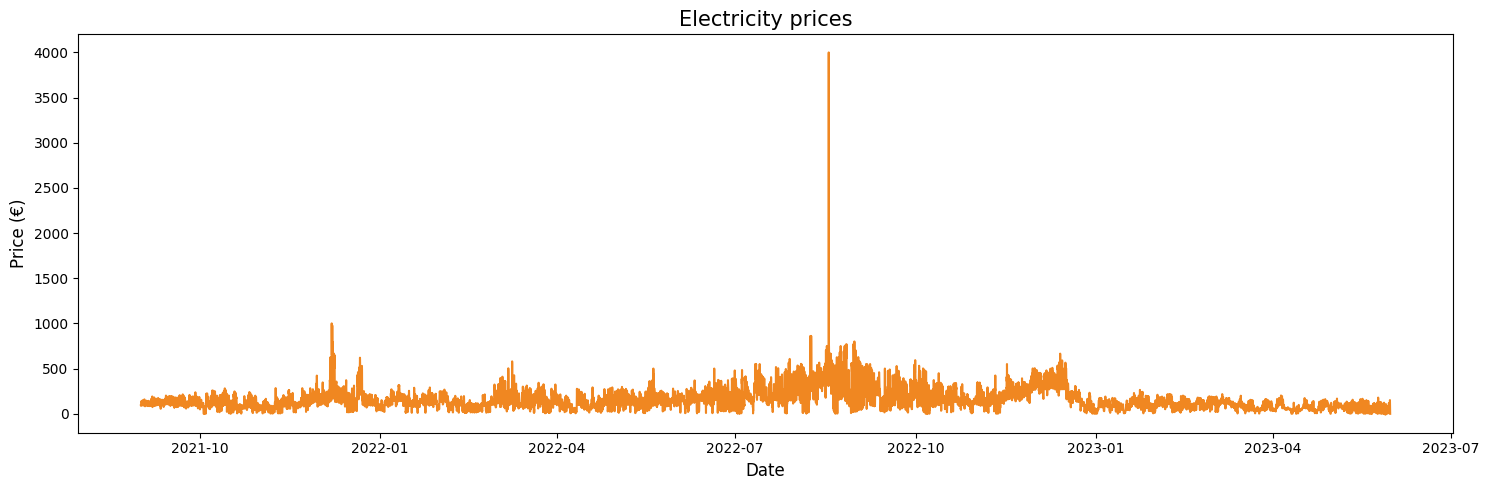

In [9]:
plot_electricity_price(electricity)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
        <ul>
        <li> There seems to be an anomaly in the time series around august 2022.</li>
        <li> We'll assume this is an anomaly in the dataset as it concerns a single hour where the price before and after seem normal.
        <li> We'll remove it and linearly interpolate the electricity price.</li>

</div>

In [10]:
electricity = remove_and_interpolate(electricity, "euros_per_mwh", threshold=2000)

<br>

<div style="background-color: #f5ab64; color: white; padding: 10px 20px 0px 20px; border-radius: 15px; font-size: 16px; border: 2px solid #f5ab64;">
    <h2>2 | Linear Program Solution</h2>
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 16px; border: 2px solid #f08721;\">
    <h4> Solution 1:   </h4>
    <ul>
        <li> Here we assume the forecast in 100% accurate.  </li>
        <li> The profit obtained is therefore conditioned on the electricity prices being exactly what we optimised over. </li>
</div>

Setting Time as Index

In [11]:
electricity.set_index('datetime_utc', inplace=True)

Group by Day to Solve Each Day Separately


In [12]:
daily_prices = electricity.groupby(electricity.index.date)

Writing the Linear Program

In [13]:
def optimise_trading_strategy(daily_prices, battery_capacity=1):
    """
    Optimise the battery trading strategy for each day in the electricity price data.

    Args:
    daily_prices (list): List of tuples containing the daily electricity prices
    battery_capacity (float): The battery capacity in MWh

    Returns:
    daily_profits (list): List of daily profits
    hourly_profits (list): List of hourly profits
    hourly_x (list): List of hourly charging decisions
    hourly_y (list): List of hourly discharging decisions
    hourly_s (list): List of hourly state of charge
    """

    daily_profits = []      # To store daily profits
    hourly_profits = []     # To store hourly profits
    hourly_x = []           # To store hourly charging decisions
    hourly_y = []           # To store hourly discharging decisions
    hourly_s = []           # To store battery's hourly state of charge

    # Loop over each day for independent optimisation
    for _, day_data in daily_prices:

        # Extract prices for the current day
        p_t = day_data["euros_per_mwh"].values  # Hourly prices for the current day
        T = len(p_t)                            # Number of hours in the current day (could be less than 24 if day not complete)

        # Define decision variables
        x = cp.Variable(T, nonneg=True)         # Charging (MWh)
        y = cp.Variable(T, nonneg=True)         # Discharging (MWh)
        s = cp.Variable(T + 1, nonneg=True)     # State of charge (MWh)

        # Objective: Maximise daily profit
        profit = cp.sum(cp.multiply(p_t, y) - cp.multiply(p_t, x))
        
        # Constraints
        constraints = [
            s[0] == 0,    # Battery starts empty
            s[T] == 0     # Battery ends empty
        ]

        # State of charge updates and capacity constraints
        for t in range(1, T + 1):
            constraints.append(s[t] == s[t - 1] + x[t - 1] - y[t - 1])  # x and y indexed by t-1 instead of t because they have one less element than s

        for t in range(T):
            constraints.append(s[t] <= battery_capacity)    # Battery capacity limit (MWh)
            constraints.append(x[t] <= 1)                   # Maximum charging rate (1 MW)
            constraints.append(y[t] <= 1)                   # Maximum discharging rate (1 MW)

        # Solve the optimisation problem for the current day
        problem = cp.Problem(cp.Maximize(profit), constraints)
        problem.solve()

        # Saving results
        daily_profits.append(problem.value)                                             # Daily profit
        hourly_profits.append(p_t * y.value - p_t * x.value)                            # Hourly profit
        hourly_x.append(x.value)                                                        # Hourly charging decisions
        hourly_y.append(y.value)                                                        # Hourly discharging decisions
        hourly_s.append(s.value)                                                        # Hourly state of charge

    return daily_profits, hourly_profits, hourly_x, hourly_y, hourly_s


Running the Linear Program

In [14]:
daily_profits, hourly_profits, hourly_x, hourly_y, hourly_s = optimise_trading_strategy(daily_prices, battery_capacity=1)

Print overall statistics

In [15]:
summarise_profits(daily_profits)

Total profit over the period: 178311.10€
Average daily profit: 279.92€
-------------------------------------
Highest daily profit: 1727.44€
Lowest daily profit: 16.60€


<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
    <ul>
        <li> We have succesfully optimised the daily profits given our contraints and assumptions. </li>
        <li> Daily profits are always positive. </li>
        <li>  This is consitent with assuming perfectly accurate price forecasts. </li>
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> We'll now visualise the data to gain further insight into the decision making. </h3>
</div>

Hourly Profits, Decisions, and Battery's State of Charge

In [16]:
hourly_s = [arr[:-1] for arr in hourly_s]       # Dropping initial state of charge (0 MWh)

Create a Hourly DataFrame

In [17]:
hourly_trading = pd.DataFrame({ "datetime_utc": electricity.index,
                                "profit": np.concatenate(hourly_profits),
                                "charging_decision": np.concatenate(hourly_x),
                                "discharging_decision": np.concatenate(hourly_y),
                                "state_of_charge": np.concatenate(hourly_s),
                                "price": electricity["euros_per_mwh"].values }
                            )

hourly_trading.head()

,datetime_utc,profit,charging_decision,discharging_decision,state_of_charge,price
0,2021-09-01 00:00:00,-4.793165e-09,0.5,5.000000e-01,1.339638e-15,92.51
1,2021-09-01 01:00:00,-6.746781e-09,0.5,5.000000e-01,5.181418e-11,88.90
2,2021-09-01 02:00:00,-2.398160e-07,0.5,5.000000e-01,1.277064e-10,87.35
3,2021-09-01 03:00:00,-8.688000e+01,1.0,1.585939e-09,2.873167e-09,86.88
4,2021-09-01 04:00:00,-2.434091e-08,0.5,5.000000e-01,1.000000e+00,88.43


Plotting Hourly Profits

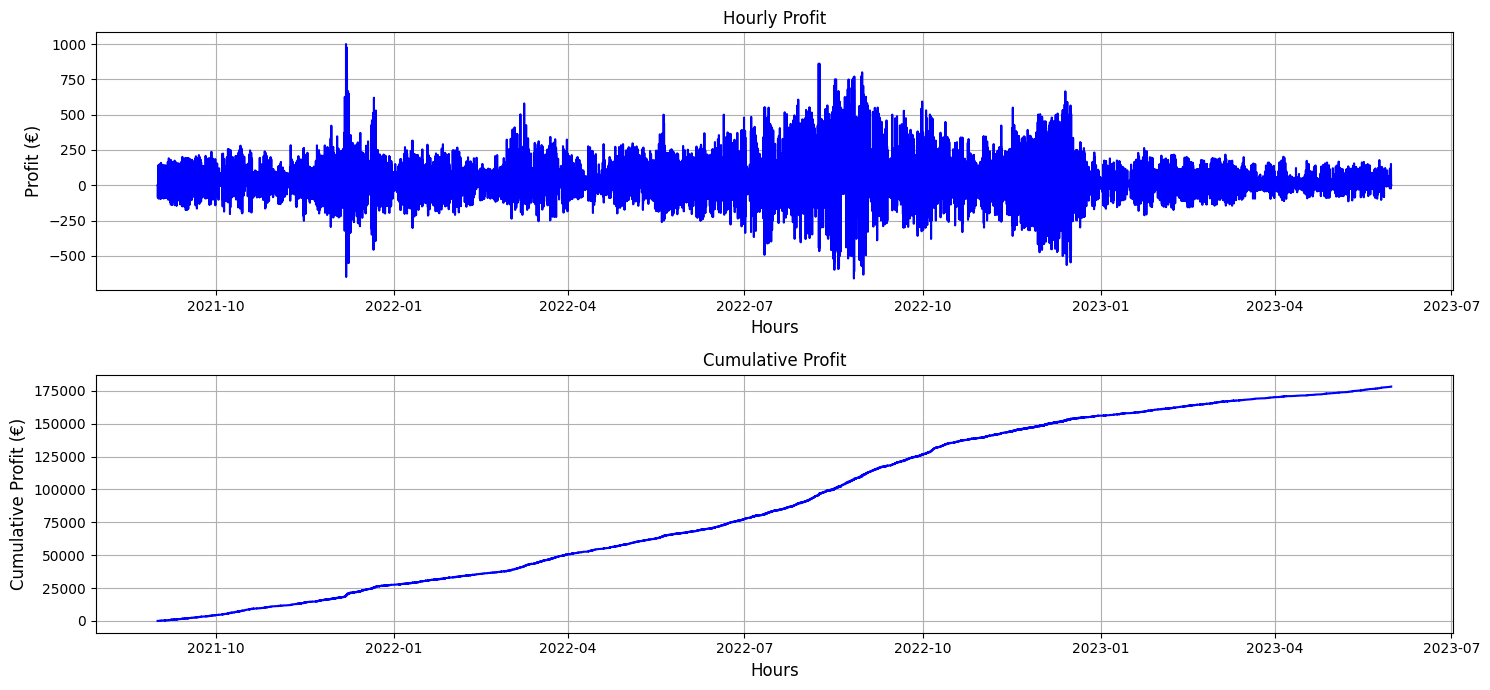

In [18]:
plot_hourly_profit(electricity, hourly_trading)

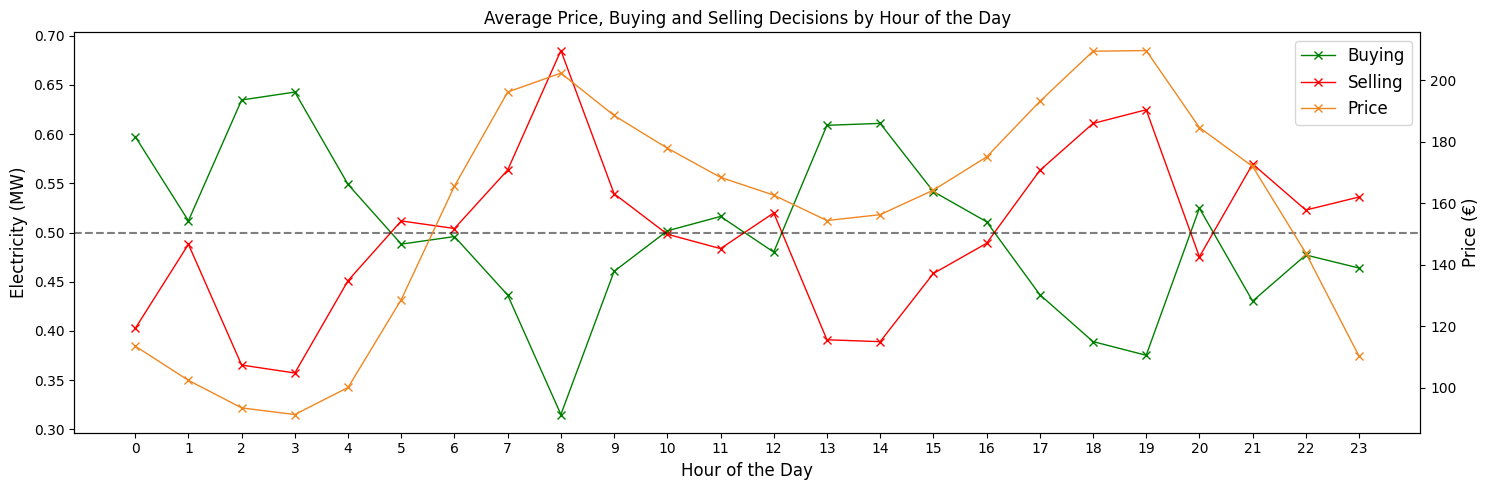

In [19]:
plot_hourly_decisions(hourly_trading)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
    <h5> On average, to maximise daily profit:  </h5>    
    <ul>
        <li> The optimal times to buy electricity are within the time intervals 1-4am and 1-4pm.  </li>
        <li> The optimal times to sell electricity are within the time intervals 6-10am and 5-7pm.  </li>
        <li> This is consistent with the general trend of electricity prices plotted in orange; buy low and sell high. </li>
    </ul>

</div>

Plotting Hourly State of Charge

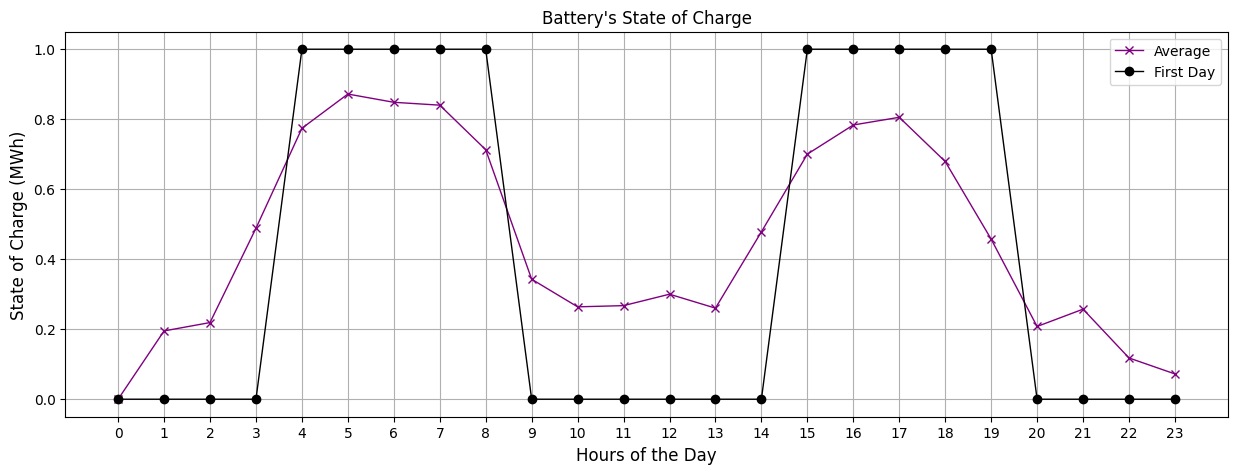

In [20]:
plot_hourly_state_of_charge(hourly_trading, hourly_s)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
    <ul>
        <li> The first day battery capacity data, shows that the battery is full from 4-8am and 3-7pm. </li>
        <li> This indicates that the storage capacity is a limiting factor to daily profits. </li>
        <li> By increasing the battery capacity, we could potentially increase daily profits. </li>
        <li> Looking only at the average battery capacity would not give us this insight. </li>
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 16px; border: 2px solid #f08721;\">
    <h4> Solution 2: Optional subtask  </h4>
    <ul>
        <li> We keep the same assumptions as in "Solution 1" but increase the battery's storage capacity to 2MWh. </li>
        <li> We assume the increase in capacity does not come with an increase in cost. </li>
</div>

Changing Battery Capacity to 2MWh

In [21]:
daily_profits_2, hourly_profits_2, hourly_x_2, hourly_y_2, hourly_s_2 = optimise_trading_strategy(daily_prices, battery_capacity=2)

Print Overall Statistics

In [22]:
summarise_profits(daily_profits_2)

Total profit over the period: 304188.22€
Average daily profit: 477.53€
-------------------------------------
Highest daily profit: 2627.76€
Lowest daily profit: 25.42€


In [23]:
hourly_s_2 = [arr[:-1] for arr in hourly_s_2]       # Dropping initial state of charge (0 MWh)

In [24]:
hourly_trading_2 = pd.DataFrame({ "datetime_utc": electricity.index,
                                "profit": np.concatenate(hourly_profits_2),
                                "charging_decision": np.concatenate(hourly_x_2),
                                "discharging_decision": np.concatenate(hourly_y_2),
                                "state_of_charge": np.concatenate(hourly_s_2),
                                "price": electricity["euros_per_mwh"].values }
                            )

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
    <ul>
        <li> By doubling the battery capacity we have increase total profit by 71% and increased the lowest and highest profits.  </li>
</div>

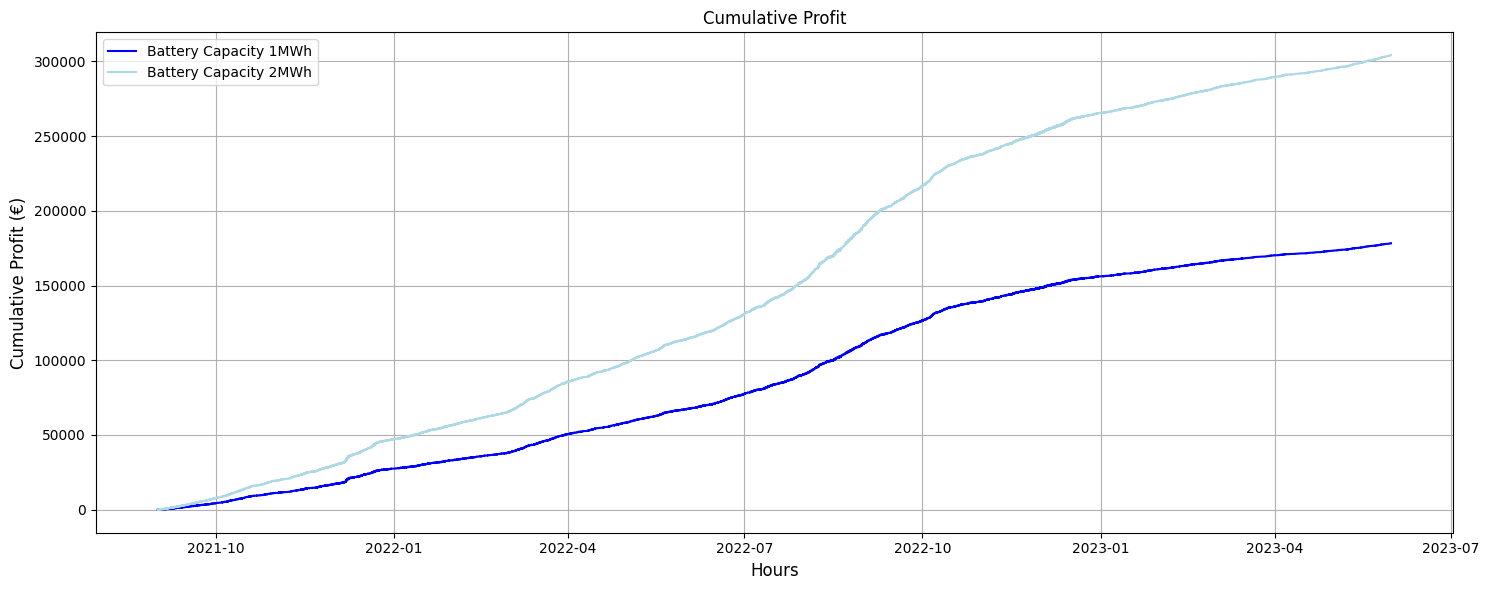

In [25]:
comparing_profits_for_different_battery_capacities(electricity, hourly_trading, hourly_trading_2)

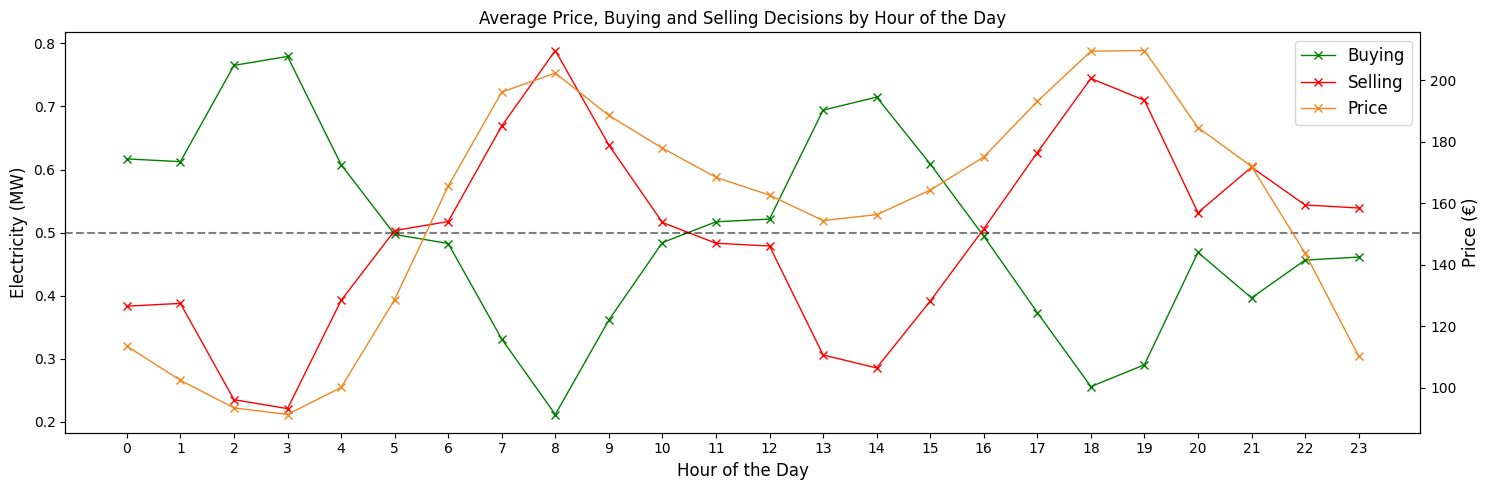

In [26]:
plot_hourly_decisions(hourly_trading_2)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
    <ul>
        <li> Trading strategy has been affected by allowing to sell more during peak price hours and buy more during low price hours. </li>
</div>

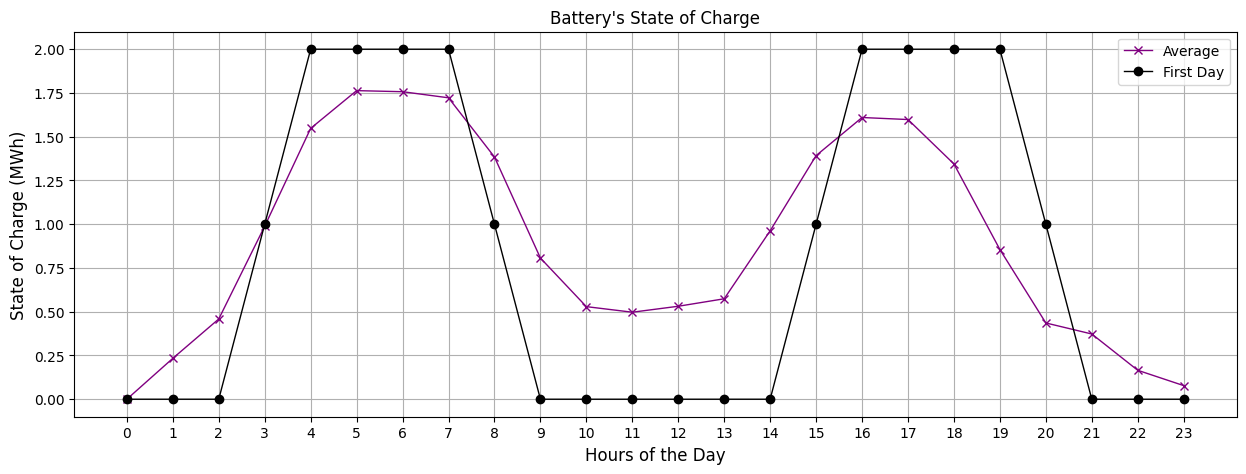

In [27]:
plot_hourly_state_of_charge(hourly_trading_2, hourly_s_2)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
    <ul>
        <li> In that first day data, we see a reduction in the number of hours where the battery capacity is full. From 8h when the capacity was 1MWh to 6h with 2MWh. </li>
        <li> This allows for more flexibility in the trading strategy. </li>
        <li> This is a simple model that assumes perfect forecasts. In reality, we would need to consider the uncertainty in the forecasts. </li>

</div>


<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 16px; border: 2px solid #f08721;\">
    <h4> Solution 3: Approximating Stochastic Optimisation using Sample Average Approximation  </h4>
    <ul>
        <li  style="margin-bottom: 10px;"> We consider a more realistic scenario where forecasts are uncertain.   </li>
        <li  style="margin-bottom: 10px;"> In reality, prices differ from forecasts; stochastic optimization helps account for this. </li> 
        <li  style="margin-bottom: 10px;"> We assume forecasted prices are normally distributed at a given time point and fit a Gaussian process. </li>
        <li  style="margin-bottom: 10px;"> Multiple electricity price trajectories are drawn from the Gaussian process. </li>
        <li  style="margin-bottom: 10px;"> A Gaussian filter with a randomly selected smoothing level is applied to the sampled prices. </li>
        <ul>
            <li  style="margin-bottom: 10px;"> This is needed because Gaussian process paths are typically less smooth than actual electricity prices. </li>
            <li  style="margin-bottom: 10px;"> Without smoothing, the linear program solution could exploit unrealistic price fluctuations, leading to higher daily profits. </li>
        </ul>
        <li  style="margin-bottom: 10px;"> To ensure diverse price time series scenarios, we use both smoothed and unsmoothed price trajectories. </li>
        <li  style="margin-bottom: 10px;"> For computational reasons, we'll only consider samples from 2021. </li>
    </ul>
</div>

Extract 2021 Data

In [28]:
y = electricity["euros_per_mwh"][electricity.index <"2022-01-01"]
x = np.arange(len(y)).reshape(-1, 1) 

Fitting Gaussian Process

In [29]:
kernel = C(1.0, (1e-3, 1e5)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e1))   # Setting the kernel (RBF)
gp = GaussianProcessRegressor(kernel=kernel, alpha=5**2)                                # Setting the Gaussian Process with high noise level (alpha)
gp.fit(x, y)                                                                            # Fitting the Gaussian Process                                             

GaussianProcessRegressor(alpha=25, kernel=1**2 * RBF(length_scale=1))

Sampling and Visualising Price Trajectories for Day 1

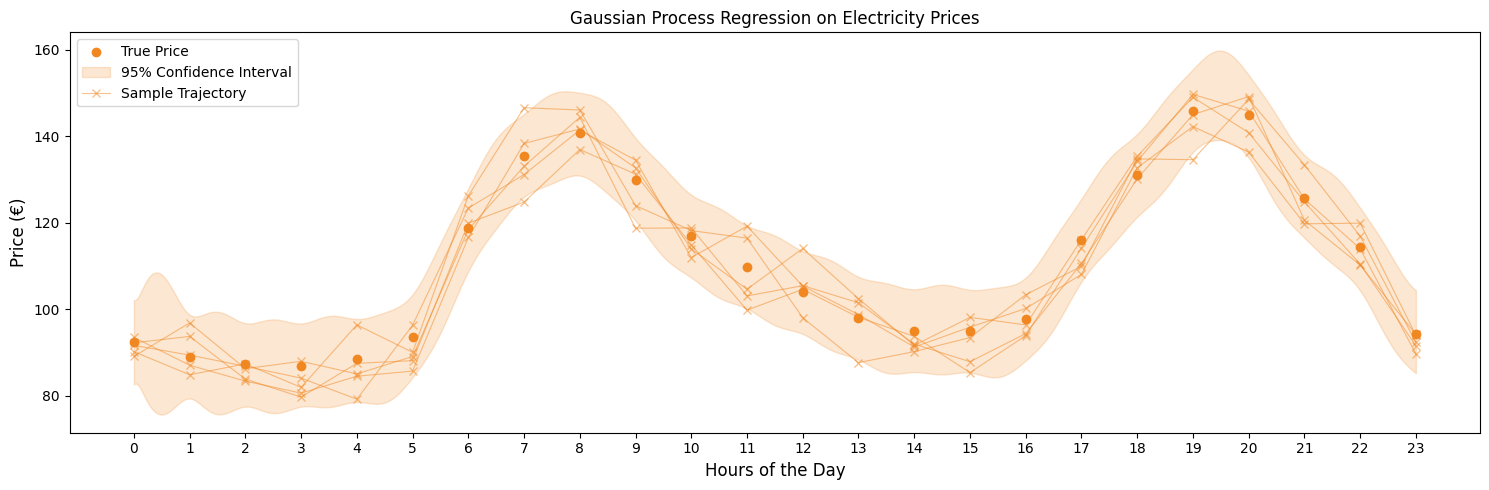

In [30]:
plot_day_price_trajectories(y, gp)

Sampling 50 Gaussian Process Price Trajectories for 2021

In [31]:
price_samples = sample_price_trajectories(n_trajectory = 50, model = gp, n_samples = len(y), length=len(y))

Randomly Smoothing Price Trajectories

In [32]:
price_samples_smoothed = smooth_dataframe(price_samples)

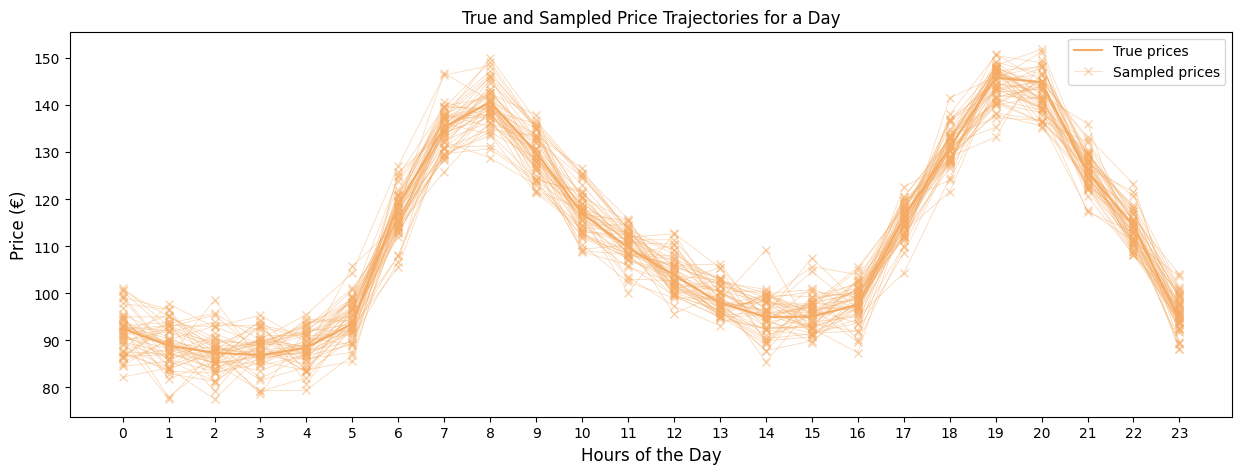

In [33]:
plot_day_price_smoothed_trajectories(y, price_samples_smoothed)

Setting Hours as Index

In [34]:
price_samples_smoothed.index = electricity.index[electricity.index <"2022-01-01"]

Sample Average Approximation (SAA)

In [35]:
def SAA_trading_strategy(price_samples, battery_capacity=1):
    """
    Optimise the battery trading strategy for each day in each sampled electricity price time series.

    Args:
    price_samples (DataFrame): Sampled electricity prices
    battery_capacity (float): The battery capacity in MWh

    Returns:
    mean_daily_profit (list): List of mean daily profits for each sampled electricity price time series
    total_profit (list): List of total profits for each sampled electricity price time series
    """

    mean_daily_profit = []      # To store mean daily profits
    total_profit = []           # To store total profits
    
    # Loop over each sampled electricity price time series for independent optimisation
    for _, daily_prices in price_samples.items():
        
        daily_profit = []      # To store daily profit

        # Group the daily prices
        daily_prices = daily_prices.groupby(daily_prices.index.date)


        # Loop over each day for independent optimisation
        for day, day_data in daily_prices:

            # Extract prices for the current day
            p_t = day_data.values                   # Hourly prices for the current day
            T = len(p_t)                            # Number of hours in the current day (could be less than 24 if day not complete)

            # Define decision variables
            x = cp.Variable(T, nonneg=True)         # Charging (MWh)
            y = cp.Variable(T, nonneg=True)         # Discharging (MWh)
            s = cp.Variable(T + 1, nonneg=True)     # State of charge (MWh)

            # Objective: Maximise daily profit
            profit = cp.sum(cp.multiply(p_t, y) - cp.multiply(p_t, x))
            
            # Constraints
            constraints = [
                s[0] == 0,    # Battery starts empty
                s[T] == 0     # Battery ends empty
            ]

            # State of charge updates and capacity constraints
            for t in range(1, T + 1):
                constraints.append(s[t] == s[t - 1] + x[t - 1] - y[t - 1])  # x and y indexed by t-1 instead of t because they have one less element than s

            for t in range(T):
                constraints.append(s[t] <= battery_capacity)    # Battery capacity limit (MWh)
                constraints.append(x[t] <= 1)                   # Maximum charging rate (1 MW)
                constraints.append(y[t] <= 1)                   # Maximum discharging rate (1 MW)

            # Solve the optimisation problem for the current day
            problem = cp.Problem(cp.Maximize(profit), constraints)
            problem.solve()

            # Saving results
            daily_profit.append(problem.value)                                      # Daily profit
        mean_daily_profit.append(np.mean(daily_profit))                         # Mean daily profit
        total_profit.append(np.sum(daily_profit))                               # Total profit for 2021

    return mean_daily_profit, total_profit


Implementing SAA (roughly 6 minutes to run)

In [36]:
mean_daily_profits, total_profits = SAA_trading_strategy(price_samples_smoothed, battery_capacity=1)

Computting LP Solution for 2021

In [37]:
# Group the daily prices
daily_prices = electricity[electricity.index <"2022-01-01"].groupby(electricity[electricity.index <"2022-01-01"].index.date)
# Running SAA
lp_daily_profits, _, _, _, _ = optimise_trading_strategy(daily_prices, battery_capacity=1)
# Summarising the results
lp_mean_daily_profit, lp_total_profit =  np.mean(lp_daily_profits), sum(lp_daily_profits)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 15px; border: 2px solid #f5ab64;\">
    <h4> Visualising the Results:</h4>
    <ul>
        <li>  We plot the density estimates of the mean daily profits and total profits obtained from the SAA method.  </li>
        <li> The LP solution is contained within the SAA results. </li>
        <li> The wide ranges in the profit densities highlight the uncertainty in the profits due to the stochastic nature of the electricity prices. </li>
</div>

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 5px; border-radius: 5px; font-size: 10px; border: 2px solid #f5ab64;\">
    <h3> Note: The uncertainty level used to generate the samples is artificial, however, in practice we could use historical and a forecasting method similar to Task 1 to estimate the uncertainty level. </h3>
</div>

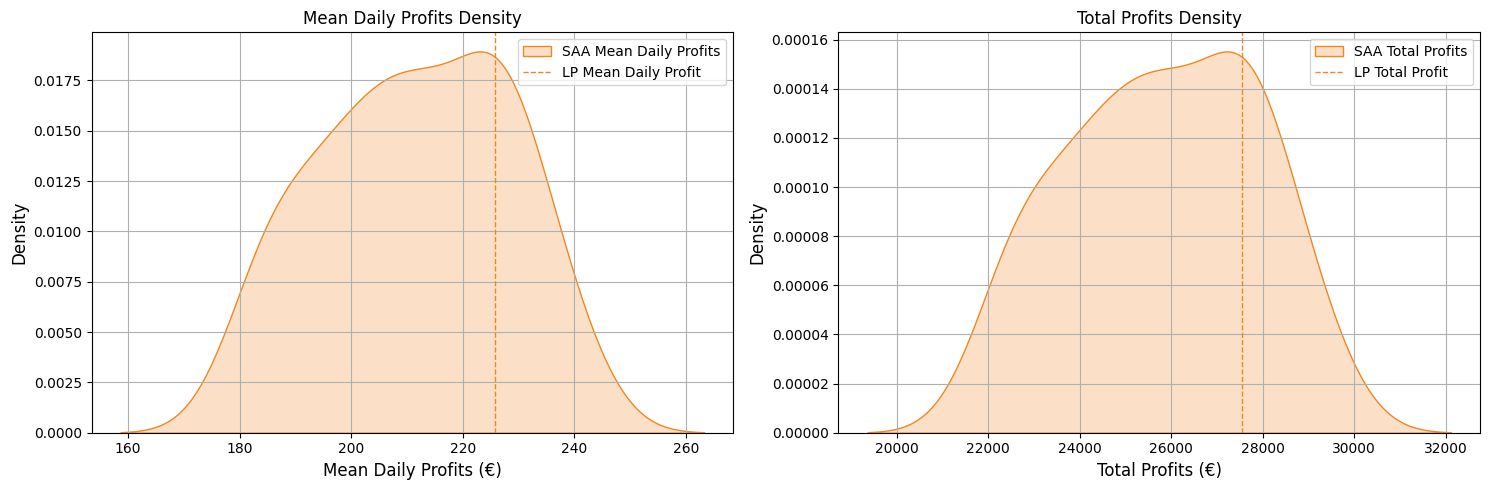

In [38]:
plot_kde_density(mean_daily_profits, lp_mean_daily_profit, total_profits, lp_total_profit)

<div style="background-color: #301b07; color: white; padding: 10px 1px 1px 10px; border-radius: 5px; font-size: 15px; border: 2px solid #f08721;\">
    <h4> Conclusion:  </h4>
    <ul>
        <li> We optimised daily profits using a linear program, assuming perfectly accurate price forecasts. </li>
        <li> We then showed that increasing battery capacity results in higher daily profits. </li>
        <li> Finally, the problem was formulated as a stochastic optimisation to account for uncertainty in profits, using Sample Average Approximation to solve it. </li>
        <li style="margin-bottom: 10px";> Using a Gaussian process instead of random white noise allow us to extend this work and optimise over different trading frequencies (by minute, half-hour, hour, day, etc.) allowing for more flexibility in the trading strategy. </li>
        <li> Further work: This problem could be solved using a dynamic program (DP), and simulate a more realistic scenario where forecasts are updated dynamically. Each hour's decision to charge or discharge the battery accounts for updated forecasts, capturing the impact of decisions on future profitability. This adaptability is crucial in real-world markets, where forecasts change frequently. While more complex, DP can better handle uncertainties and optimise profits across a longer time horizon. Combining these methods — using LP for stable, predictable markets and DP for dynamic, uncertain markets — can provide a comprehensive strategy for maximising daily profits. </li>


</div>